### Set Up

#### Imports

In [1]:
import os
import random

import numpy as np
from scipy.interpolate import griddata
import astropy.io.fits as FITS
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, UpSampling1D, Conv1D, Reshape, Flatten, MaxPooling1D, Conv2D
from keras.models import Model, Sequential, load_model
import tensorflow as tf
from scipy.ndimage import gaussian_filter
from scipy.stats import chisquare, mode
from sklearn.decomposition import PCA, IncrementalPCA
from keras import optimizers

#plotting
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Opening FITS

In [4]:
atmos = FITS.open("50G.ngrey.288x100x288_atmos_61.fits")[0].data
print(atmos.shape)
atmos[9]/=-1e5 #cm to km

log_tau=atmos[0,:,0][0] #log tau

(12, 288, 288, 61)


#### Bounds & Min/Max Vals

In [5]:
u = 11
l = 61
ND = (l-u)

In [6]:
cut_atmos = atmos[:,:,:,u:l].reshape(12,288*288,ND) 
cut_temp = cut_atmos[2,:,:]

cut_vlos = cut_atmos[9,:,:]

max_cut_temp = np.max(cut_temp)
min_cut_temp = np.min(cut_temp)

max_cut_vlos = np.max(cut_vlos)
min_cut_vlos = np.min(cut_vlos)

print(min_cut_vlos)

-11.853521775739175


#### Setting up Normalizing Functions

In [7]:
#function to normalize data
def normalize(val, max_val, min_val):
    a = (val - min_val)
    b = (max_val - min_val)
    return (a/b)

In [9]:
def normalize_all(arr, max_val, min_val):
    arr2 = np.empty(arr.shape)
    for i in range(0,arr.shape[0]):
        for j in range(0,arr.shape[1]):
            arr2[i,j] = normalize(arr[i,j],max_val,min_val)
    return arr2

#### Normalizing

In [10]:
norm_temp = normalize_all(cut_temp,max_cut_temp,min_cut_temp) #normalizing

In [11]:
norm_vlos = normalize_all(cut_vlos,max_cut_vlos,min_cut_vlos) #normalizing

#### Training Set Split

Use random state from other testing for direct comparison plots!

In [13]:
#split into training/validation
train_temp, test_temp, _ , _ = train_test_split(norm_temp, norm_temp, test_size=0.25, random_state=39)
print(train_temp.shape)
print(test_temp.shape)

#split into training/validation
train_vlos, test_vlos, _ , _ = train_test_split(norm_vlos, norm_vlos, test_size=0.25, random_state=39)
print(train_vlos.shape)
print(test_vlos.shape)

(62208, 50)
(20736, 50)
(62208, 50)
(20736, 50)


### Training & Initial Look at Results

#### Model Fitting (temp)

In [28]:
n_comp = 10
ipca = IncrementalPCA(n_components=n_comp, batch_size=32)
temp_transformed = ipca.fit_transform(train_temp)

In [29]:
temp_compressed = ipca.inverse_transform(temp_transformed)

#### Validation Data

In [30]:
temp_trans_valid = ipca.transform(test_temp)
temp_preds = ipca.inverse_transform(temp_trans_valid)

#### Plotting Comparison Example

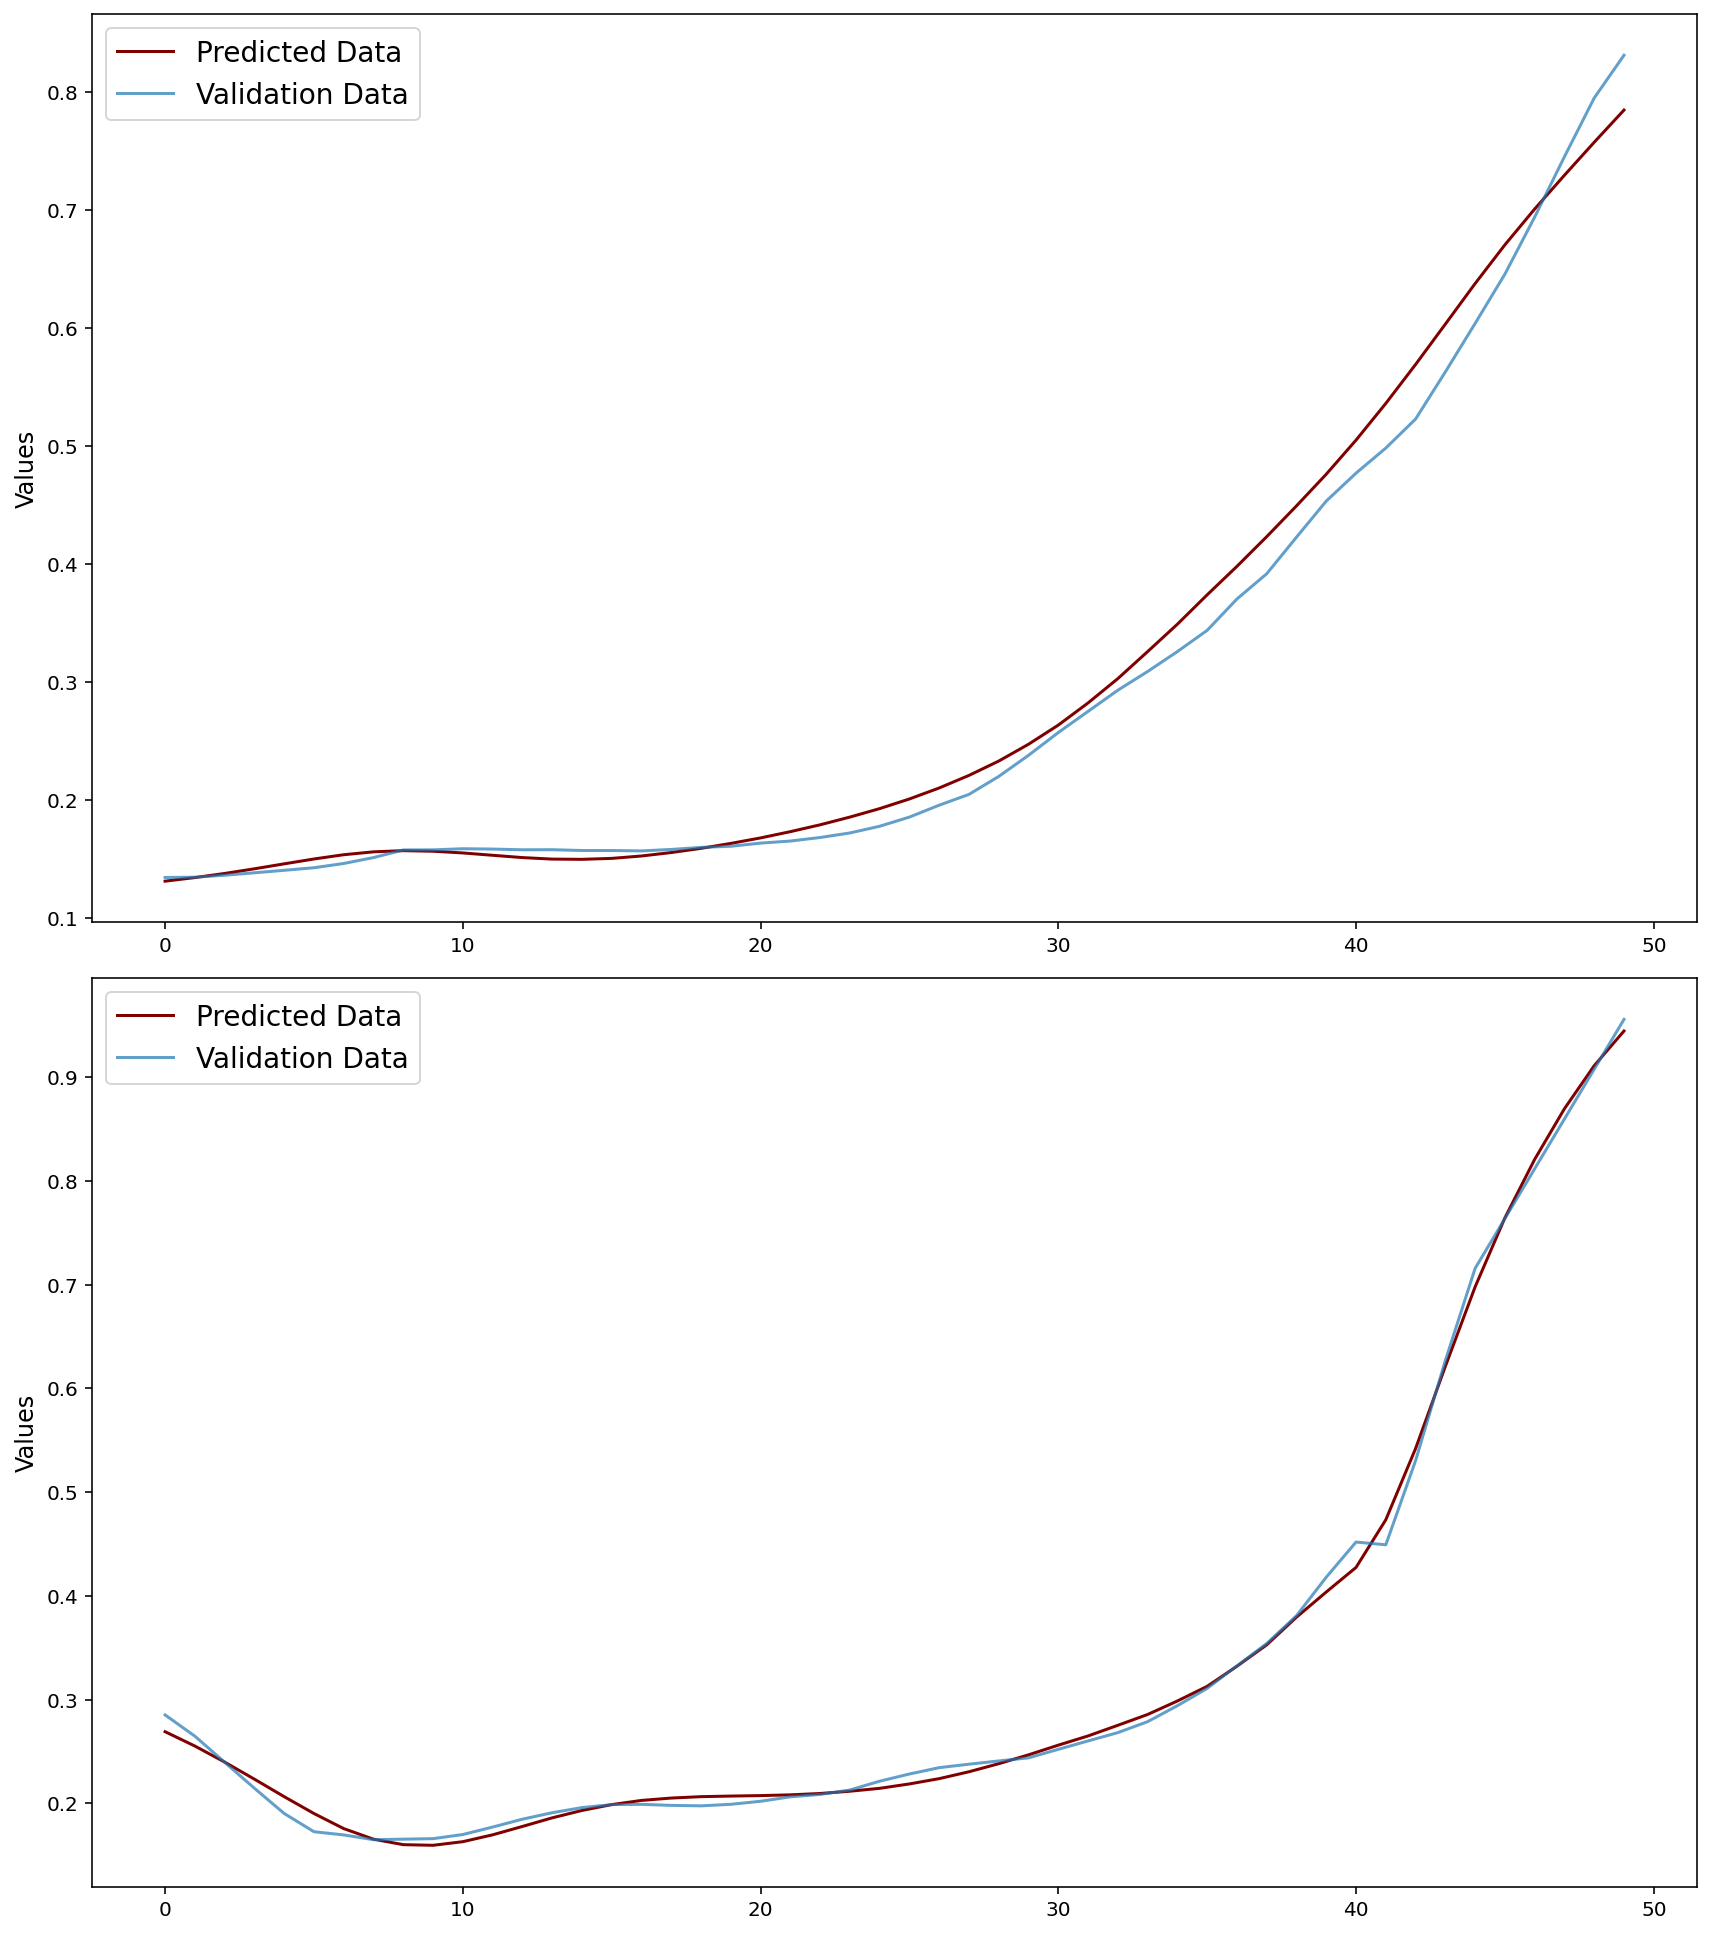

In [31]:
#temperature
fig1 = plt.figure(figsize=(12,20))

#example temp @ 0
ax7 = fig1.add_subplot(3,1,1)
ax7.plot(temp_preds[0], color="maroon", label="Predicted Data")
ax7.plot(train_temp[0], alpha=0.7, label="Validation Data")
#ax7.set_title("Validation Data vs Predicted Data (i=0)", fontsize=14)
ax7.set_ylabel("Values", fontsize=12)
ax7.legend(loc="best", frameon=True, fontsize=14)

#example vlos @ 0
ax9 = fig1.add_subplot(3,1,2)
ax9.plot(temp_preds[500], color="maroon", label="Predicted Data")
ax9.plot(test_temp[500], alpha=0.7, label="Validation Data")
#ax9.set_title("Validation Data vs Predicted Data (i=5000)", fontsize=14)
ax9.set_ylabel("Values", fontsize=12)
ax9.legend(loc="best", frameon=True, fontsize=14)

fig1.tight_layout()
#fig1.savefig("Nice/preds112-O2.png")

#### Model Fitting (vlos)

In [32]:
n_comp = 14
ipca2 = IncrementalPCA(n_components=n_comp, batch_size=32)
vlos_transformed = ipca2.fit_transform(train_vlos)

In [33]:
vlos_compressed = ipca2.inverse_transform(vlos_transformed)

#### Validation Data

In [34]:
vlos_trans_valid = ipca2.transform(test_vlos)
vlos_preds = ipca2.inverse_transform(vlos_trans_valid)

#### Plotting Comparison

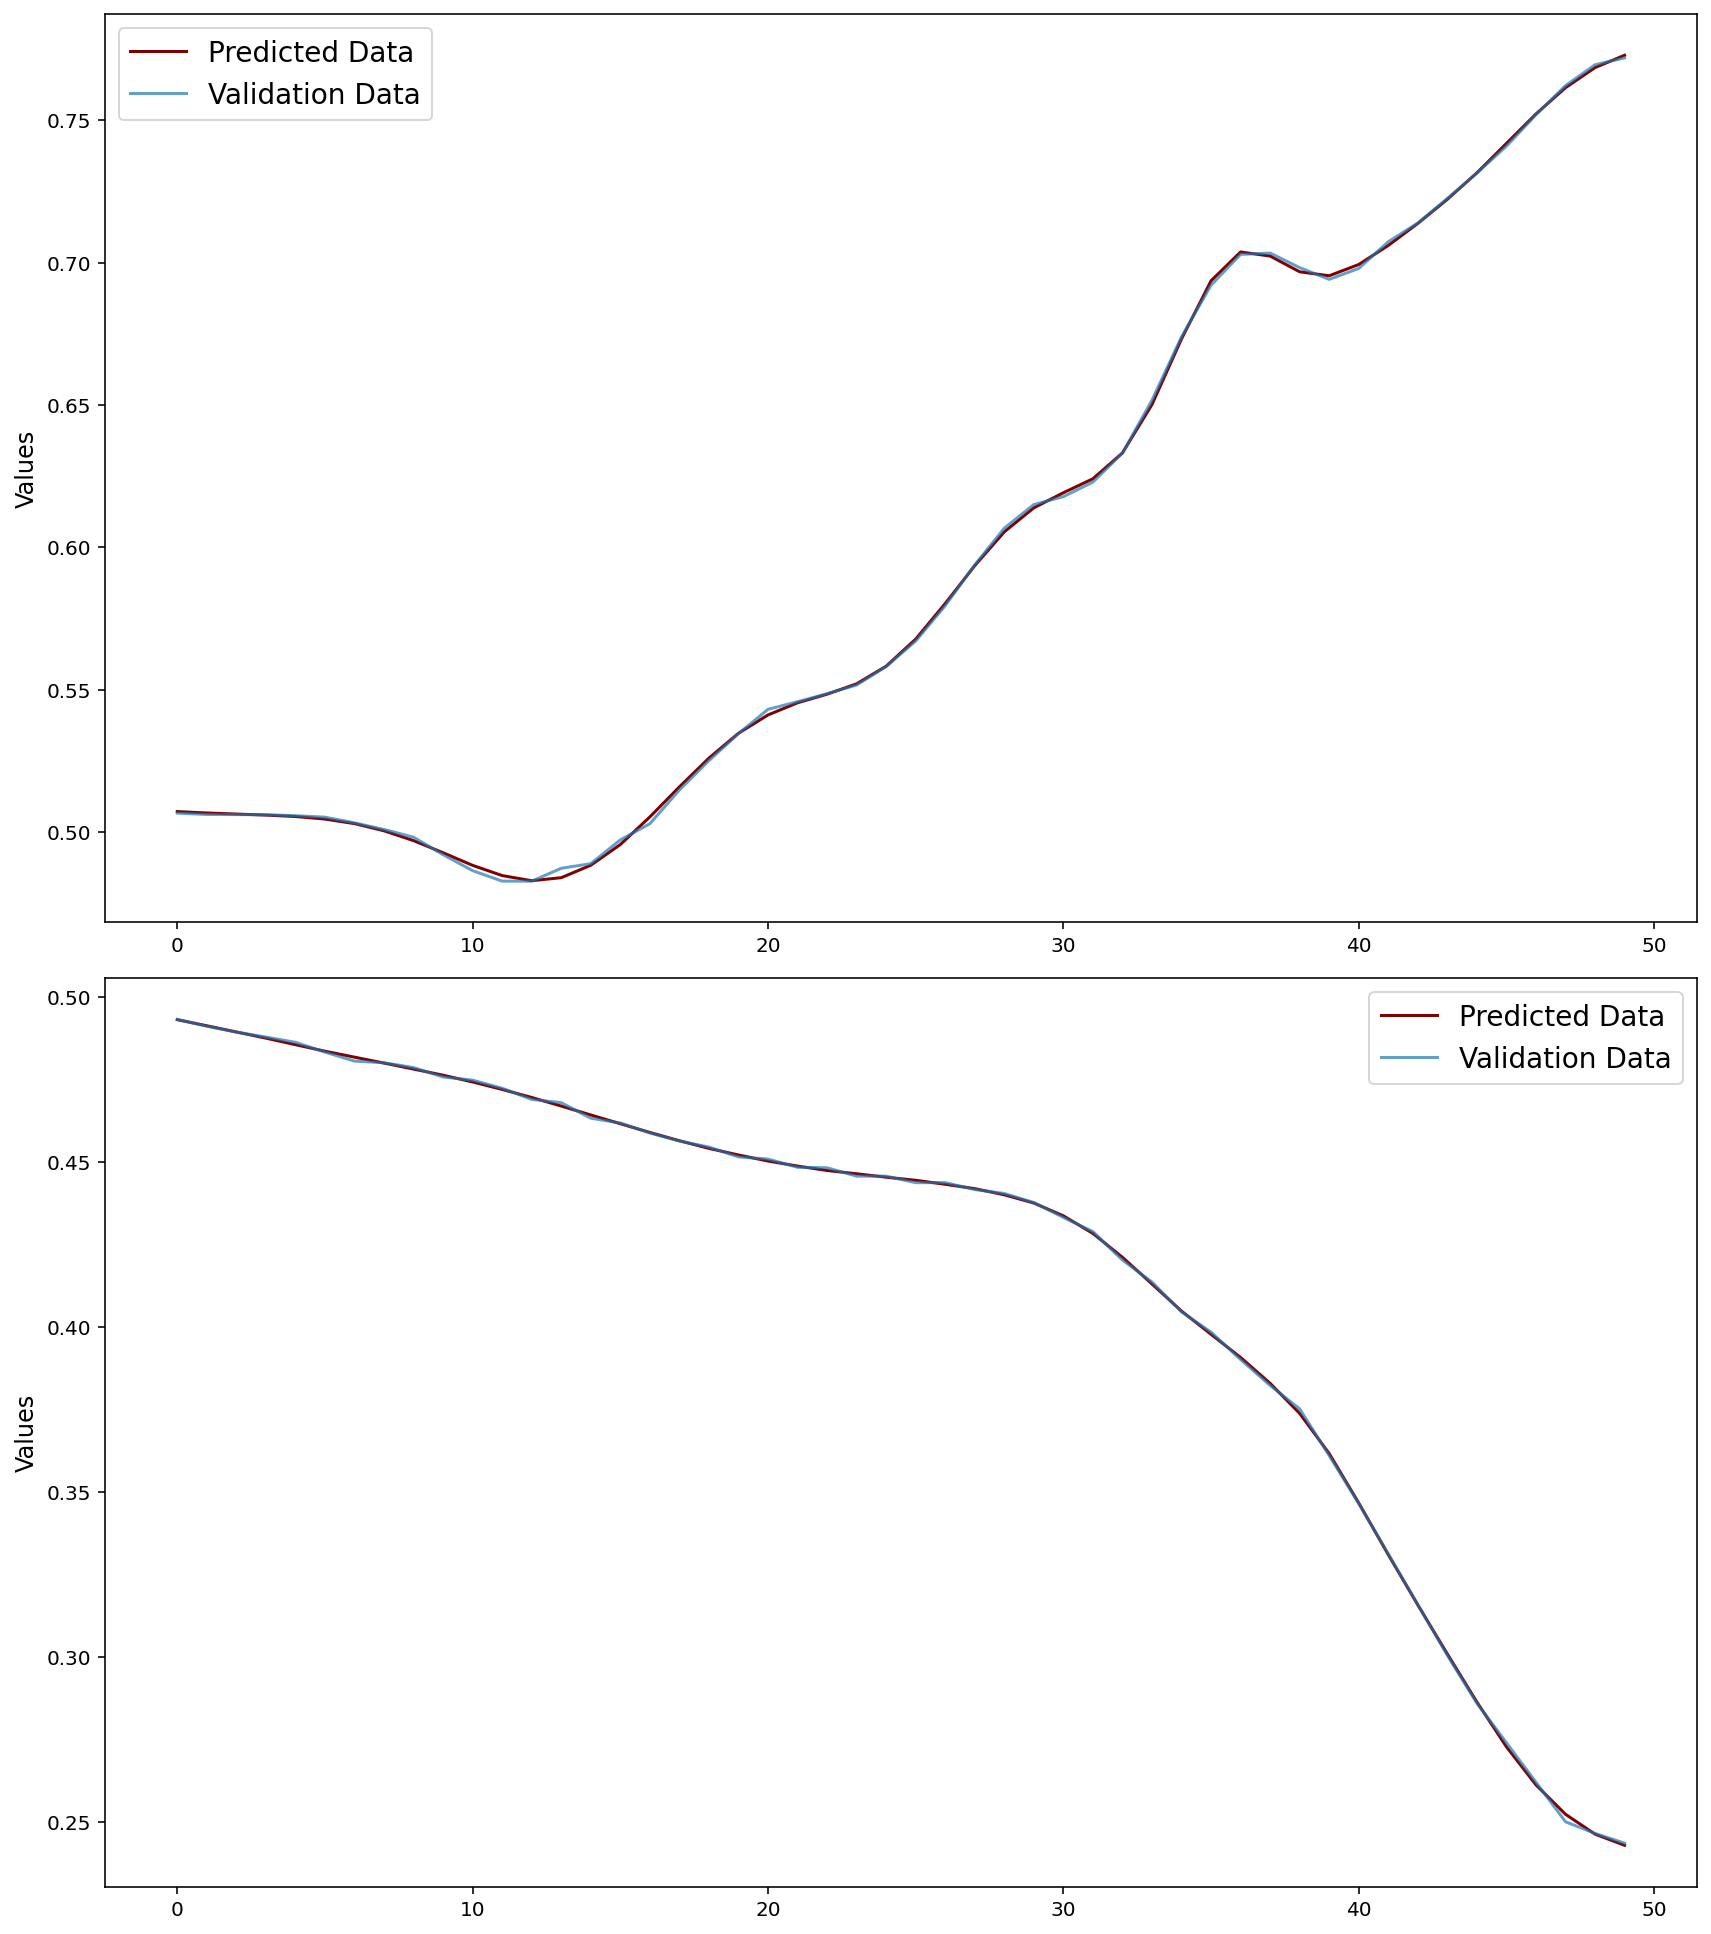

In [35]:
#temperature
fig2 = plt.figure(figsize=(12,20))

#example temp @ 0
ax7 = fig2.add_subplot(3,1,1)
ax7.plot(vlos_preds[54,:], color="maroon", label="Predicted Data")
ax7.plot(test_vlos[54,:], alpha=0.7, label="Validation Data")
#ax7.set_title("Validation Data vs Predicted Data (i=0)", fontsize=14)
ax7.set_ylabel("Values", fontsize=12)
ax7.legend(loc="best", frameon=True, fontsize=14)

#example vlos @ 0
ax9 = fig2.add_subplot(3,1,2)
ax9.plot(vlos_preds[5,:], color="maroon", label="Predicted Data")
ax9.plot(test_vlos[5,:], alpha=0.7, label="Validation Data")
#ax9.set_title("Validation Data vs Predicted Data (i=5000)", fontsize=14)
ax9.set_ylabel("Values", fontsize=12)
ax9.legend(loc="best", frameon=True, fontsize=14)

fig2.tight_layout()
#fig1.savefig("Nice/preds112-O2.png")

## Packaging up Results

#### Denormalizing

In [23]:
# We need to denormalize and save
def de_normalize_all(arr, max_val, min_val):
    arr2 = np.empty(arr.shape)
    for i in range(0,arr.shape[0]):
        for j in range(0,arr.shape[1]):
            arr2[i,j] = arr[i,j]*(max_val-min_val) + min_val
    return arr2

In [36]:
preds_1i = ipca.transform(norm_temp) #make the preds
preds_1 = ipca.inverse_transform(preds_1i)

denorm_preds_1 = de_normalize_all(preds_1,max_cut_temp,min_cut_temp)
denorm_og_1 = de_normalize_all(norm_temp,max_cut_temp,min_cut_temp)

In [37]:
preds_2i = ipca2.transform(norm_vlos) #make the preds
preds_2 = ipca2.inverse_transform(preds_2i)

denorm_preds_2 = de_normalize_all(preds_2,max_cut_vlos,min_cut_vlos)
denorm_og_2 = de_normalize_all(norm_vlos,max_cut_vlos,min_cut_vlos)

#### Parameter Maps

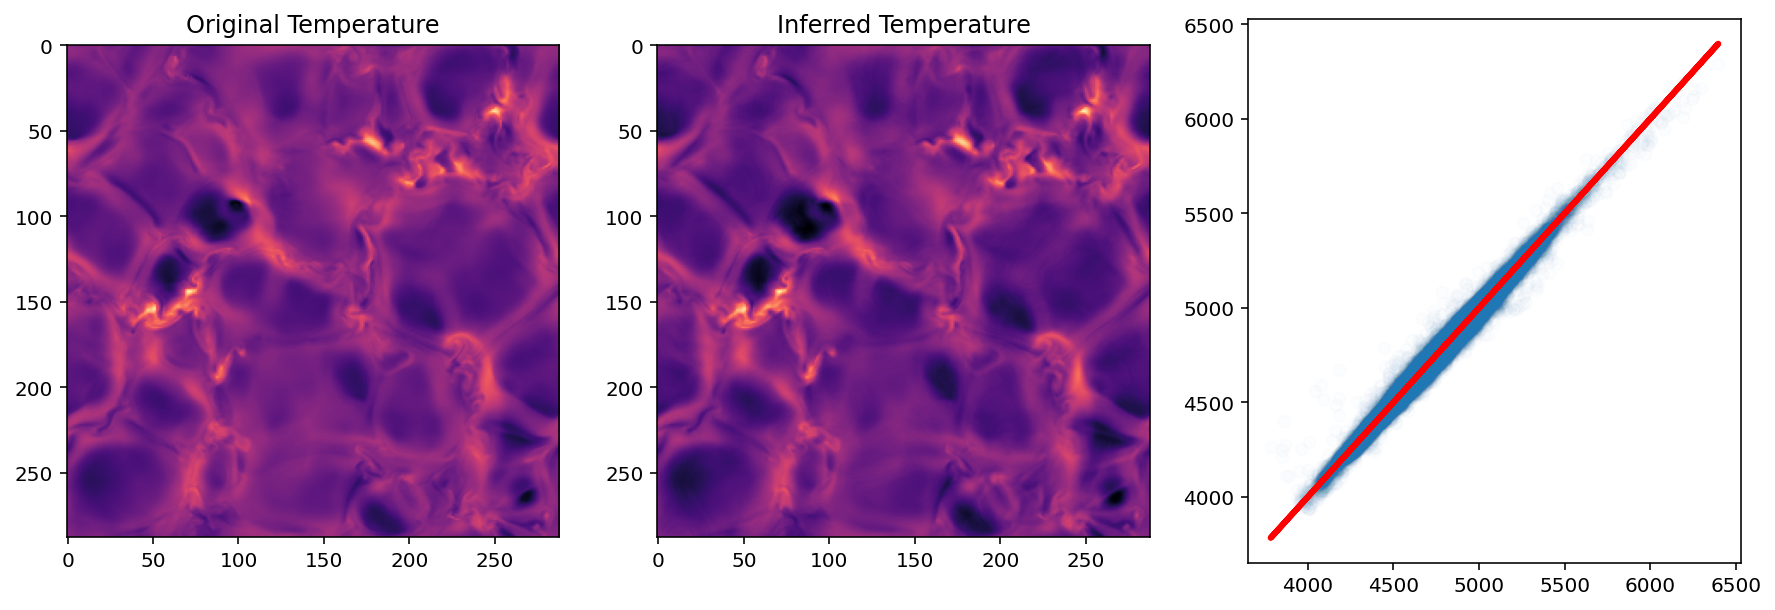

In [38]:
# Now we can, out of curiosity plot maps of parameters:
d = -30
plt.figure(figsize=[15,5])
plt.subplot(131)
plt.imshow(denorm_og_1[:,d].reshape(288,288),cmap='magma')
plt.title("Original Temperature")
plt.subplot(132)
plt.imshow(denorm_preds_1[:,d].reshape(288,288),cmap='magma')
plt.title("Inferred Temperature")
plt.subplot(133)
plt.scatter(denorm_og_1[:,d],denorm_preds_1[:,d],alpha=0.01)
plt.plot(denorm_og_1[:,d],denorm_og_1[:,d],linewidth=3,color='red')

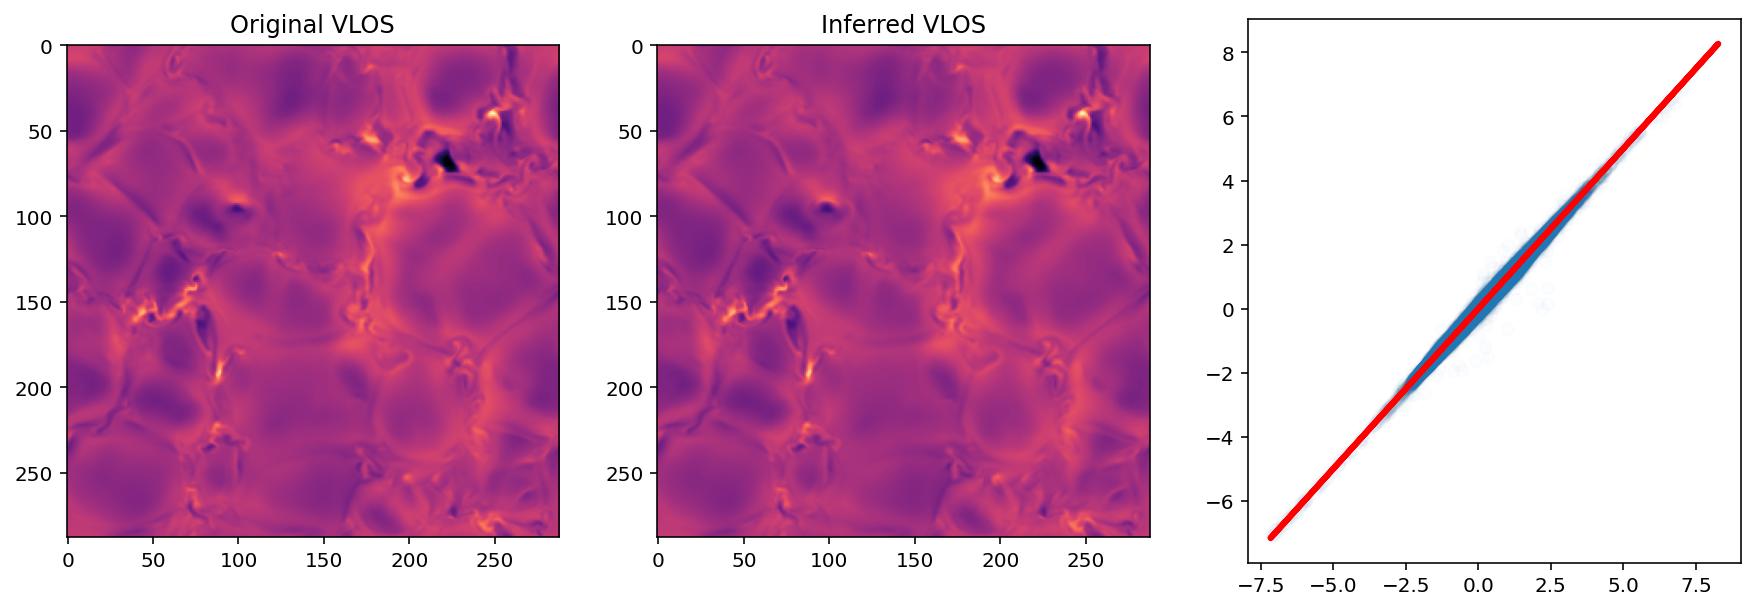

In [39]:
# Now we can, out of curiosity plot maps of parameters:
d = -30
plt.figure(figsize=[15,5])
plt.subplot(131)
plt.imshow(denorm_og_2[:,d].reshape(288,288),cmap='magma')
plt.title("Original VLOS")
plt.subplot(132)
plt.imshow(denorm_preds_2[:,d].reshape(288,288),cmap='magma')
plt.title("Inferred VLOS")
plt.subplot(133)
plt.scatter(denorm_og_2[:,d],denorm_preds_2[:,d],alpha=0.01)
plt.plot(denorm_og_2[:,d],denorm_og_2[:,d],linewidth=3,color='red')

#### Packaging to FITS

In [40]:
atmos_new = np.copy(atmos)
atmos_new = atmos_new[:,:,:,u:l]
atmos_new[2] = np.copy(denorm_preds_1.reshape(288,288,50))
atmos_new[9] = np.copy(denorm_preds_2.reshape(288,288,50)*-1e5)
print(np.min(atmos_new[9]))

-1118521.2032799253


In [41]:
myhdu = FITS.PrimaryHDU(atmos_new)
myhdu.writeto("50G.ngrey.288x100x288_atmos_50_compressed-pca.fits",overwrite='True')

### Analyzing Results

In [42]:
atmos_comp = FITS.open("50G.ngrey.288x100x288_atmos_50_compressed-pca.fits")[0].data
atmos_comp[9]/=-1e5 #cm to km
formatted_atmos_comp = atmos_comp.reshape(12,288*288,50)
print(formatted_atmos_comp.shape)

atmos = FITS.open("50G.ngrey.288x100x288_atmos_61.fits")[0].data
atmos[9]/=-1e5 #cm to km
formatted_atmos = atmos[:,:,:,u:l].reshape(12,288*288,50) 
print(formatted_atmos.shape)

(12, 82944, 50)
(12, 82944, 50)


#### RMSE

In [44]:
def rmse_func(sp1,sp2):
    assert (len(sp1) == len(sp2)), "Arrays aren't same length?"
    num = (sp1-sp2)
    ans = np.sum(np.square(num))/len(sp1)
    return np.sqrt(ans)

In [46]:
rmse_arr_temp = []

for i in range(0,82944):
        rmse_arr_temp.append(rmse_func(formatted_atmos_comp[2,i],formatted_atmos[2,i]))
    
rmse_arr_temp = np.asarray(rmse_arr_temp)

mean: 27.842
med: 25.265


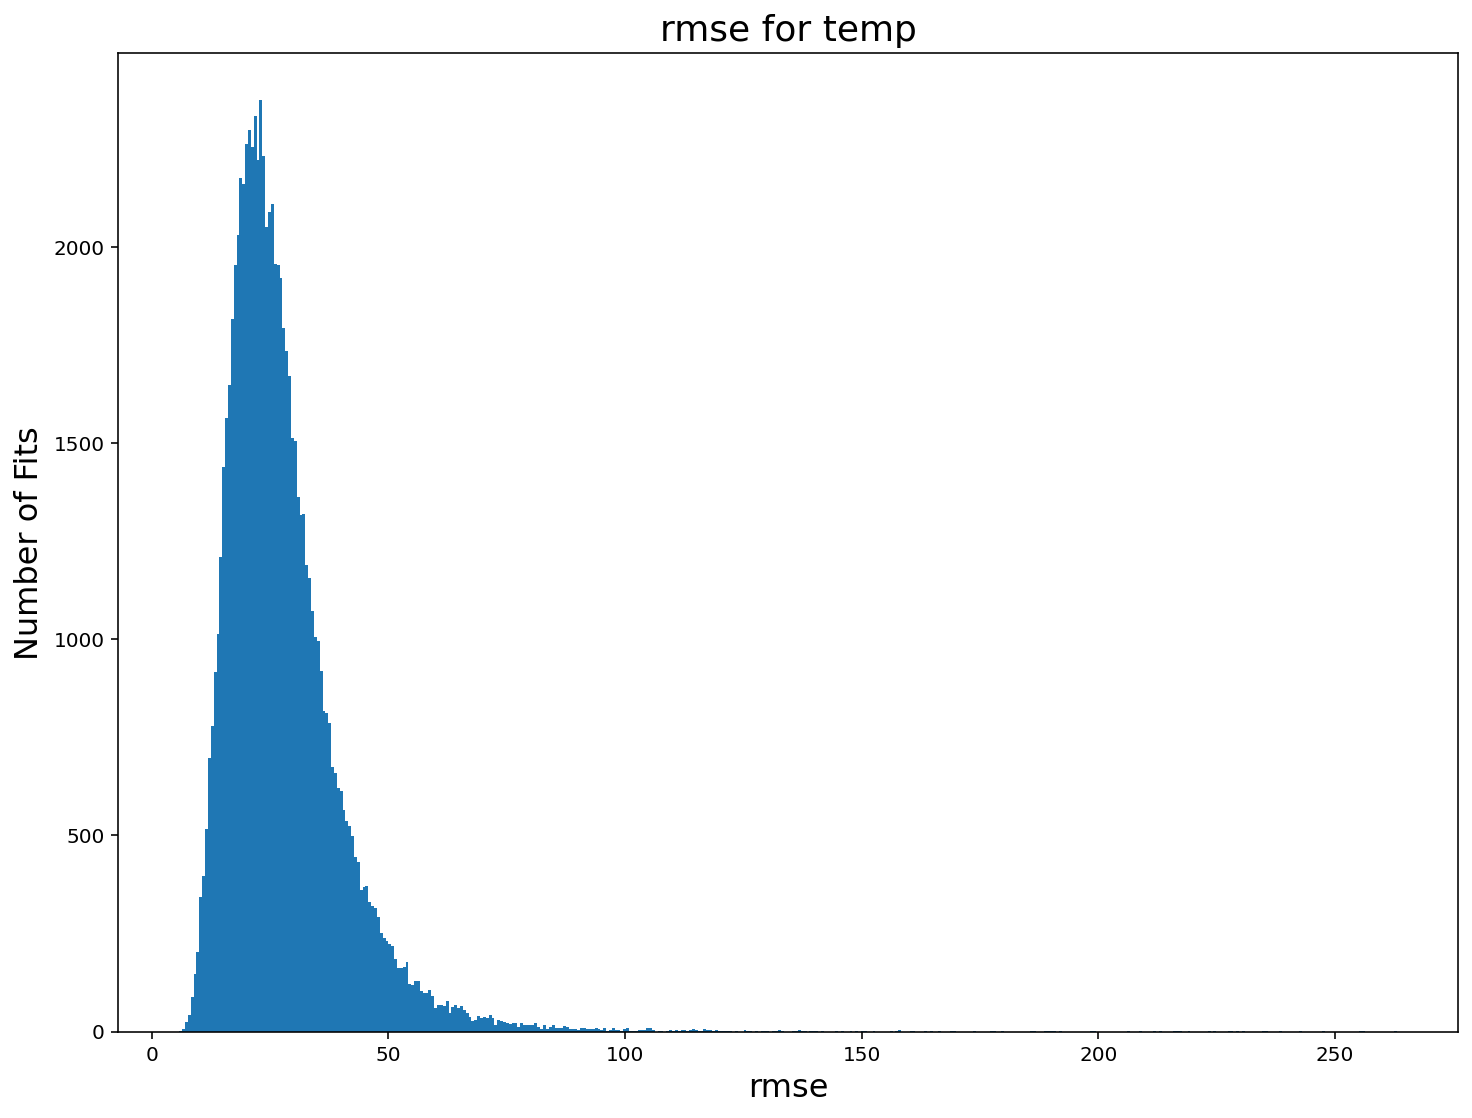

In [48]:
fig4 = plt.figure(figsize=(12,9))

#example spectra @10000
ax1 = fig4.add_subplot(1,1,1)
ax1.hist(rmse_arr_temp, bins='auto')
ax1.set_title("", fontsize=18)
ax1.set_xlabel("rmse", fontsize=16)
ax1.set_title("rmse for temp", fontsize=18)
ax1.set_ylabel("Number of Fits", fontsize=16)

print("mean:", np.round(np.mean(rmse_arr_temp),3))
print("med:", np.round(np.median(rmse_arr_temp),3))

In [49]:
rmse_arr_vlos = []

for i in range(0,82944):
        rmse_arr_vlos.append(rmse_func(formatted_atmos_comp[9,i],formatted_atmos[9,i])) #what val for noise?
    
rmse_arr_vlos = np.asarray(rmse_arr_vlos)

mean: 0.044
med: 0.036


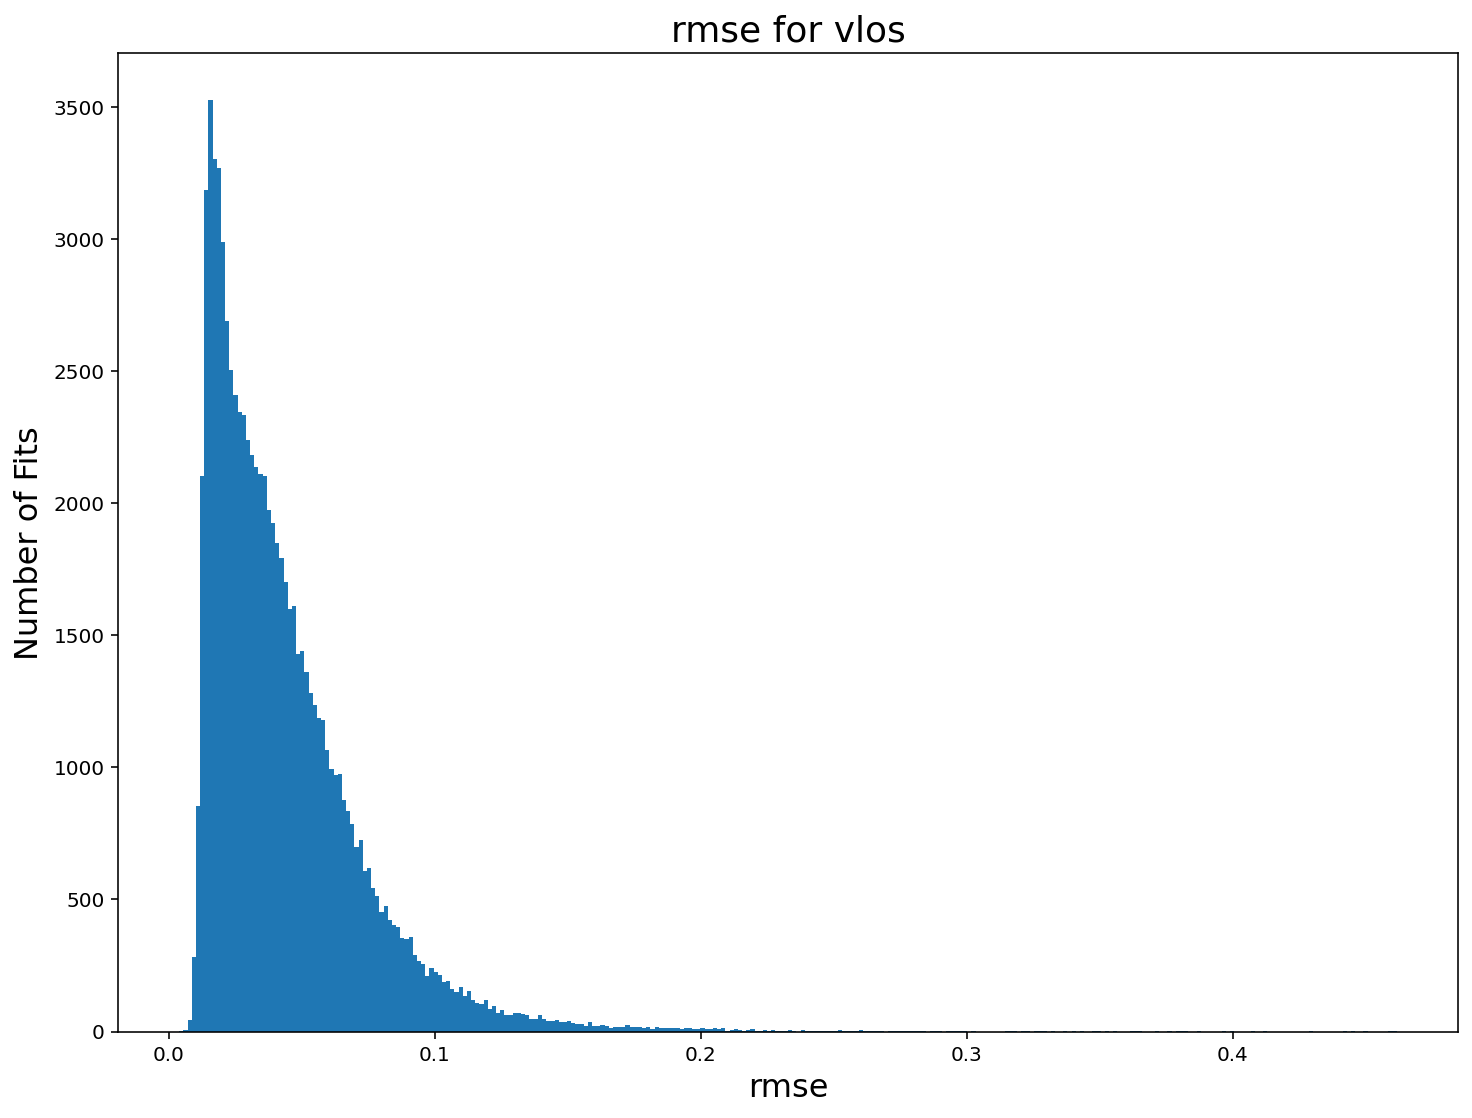

In [50]:
fig4 = plt.figure(figsize=(12,9))

#example spectra @10000
ax1 = fig4.add_subplot(1,1,1)
ax1.hist(rmse_arr_vlos,bins='auto')
#ax1.hist(chisq_arr_temp)
ax1.set_title("rmse for vlos", fontsize=18)
ax1.set_xlabel("rmse", fontsize=16)
ax1.set_ylabel("Number of Fits", fontsize=16)

print("mean:", np.round(np.mean(rmse_arr_vlos),3))
print("med:", np.round(np.median(rmse_arr_vlos),3))

In [51]:
print(formatted_atmos_comp.shape)

(12, 82944, 50)


#### STDEV

In [52]:
stdev_arr_temp = []

for i in range(0,50):
    stdev_arr_temp.append(np.std(formatted_atmos_comp[2,:,i]-formatted_atmos[2,:,i]))
    
stdev_arr_temp = np.asarray(stdev_arr_temp)

Text(0, 0.5, 'stdev')

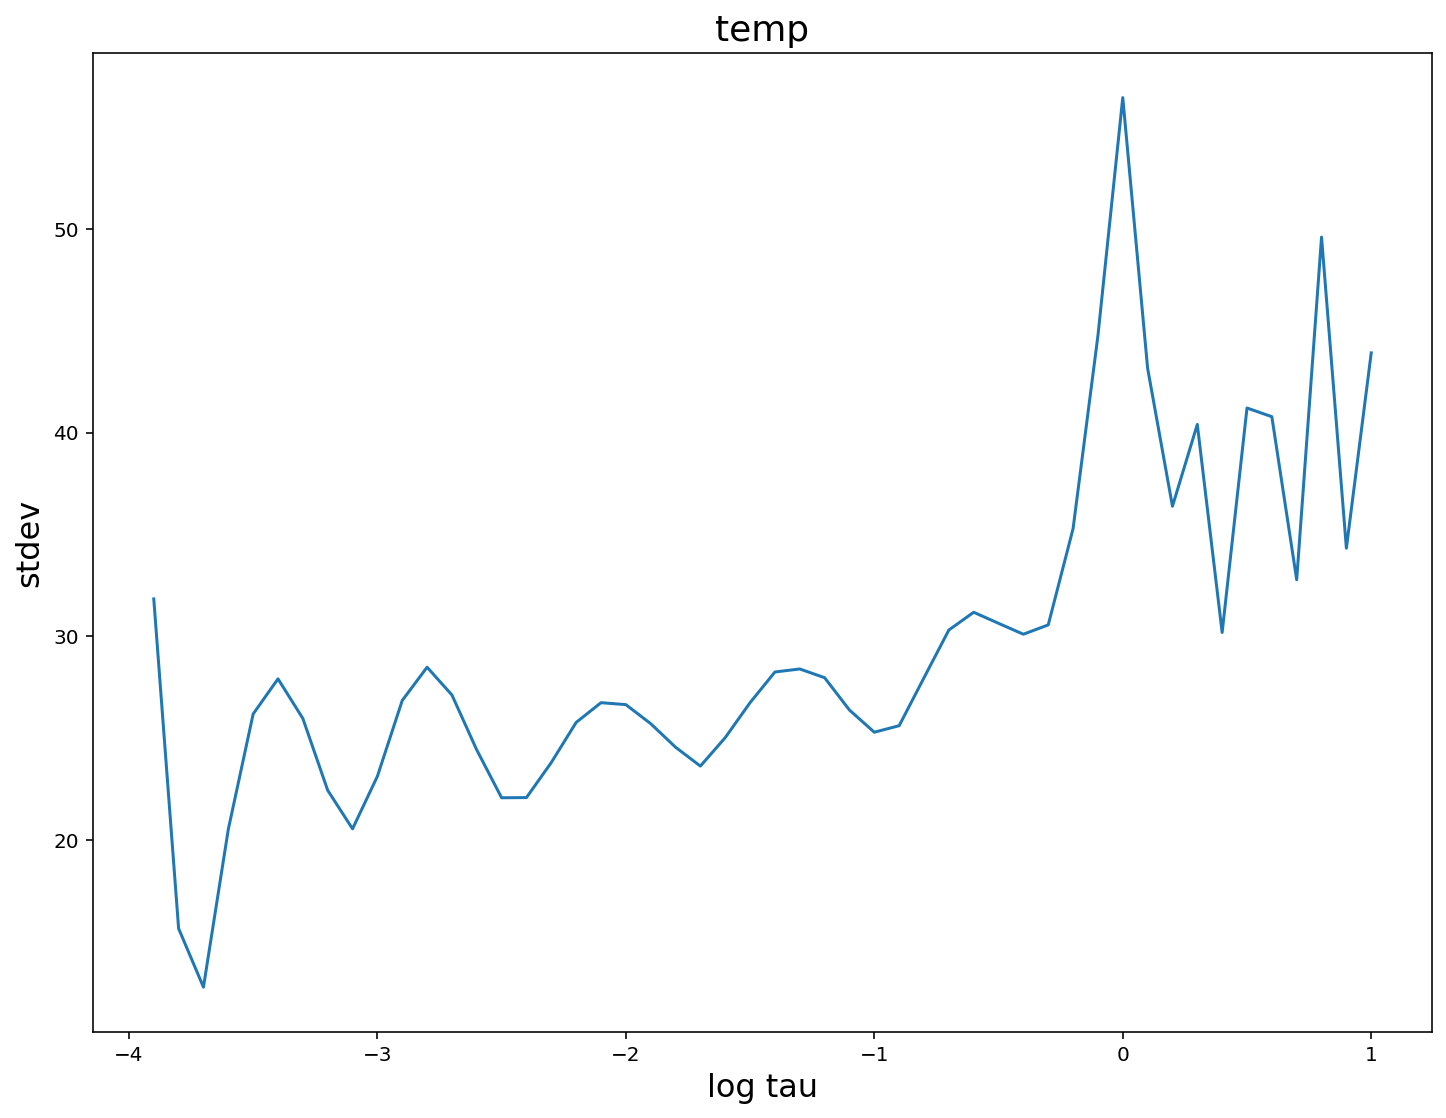

In [53]:
fig5 = plt.figure(figsize=(12,9))

#example spectra @10000
ax1 = fig5.add_subplot(1,1,1)
ax1.plot(atmos[0,:,0][0][u:l], stdev_arr_temp)
#ax1.hist(chisq_arr_temp)
ax1.set_title("temp", fontsize=18)
ax1.set_xlabel("log tau", fontsize=16)
ax1.set_ylabel("stdev", fontsize=16)

#fig4.savefig("Nice/hist112-test-O2.png")

In [54]:
stdev_arr_vlos = []

for i in range(0,50):
    stdev_arr_vlos.append(np.mean(formatted_atmos_comp[9,:,i]-formatted_atmos[9,:,i]))
    
stdev_arr_vlos = np.asarray(stdev_arr_vlos)

Text(0, 0.5, 'stdev')

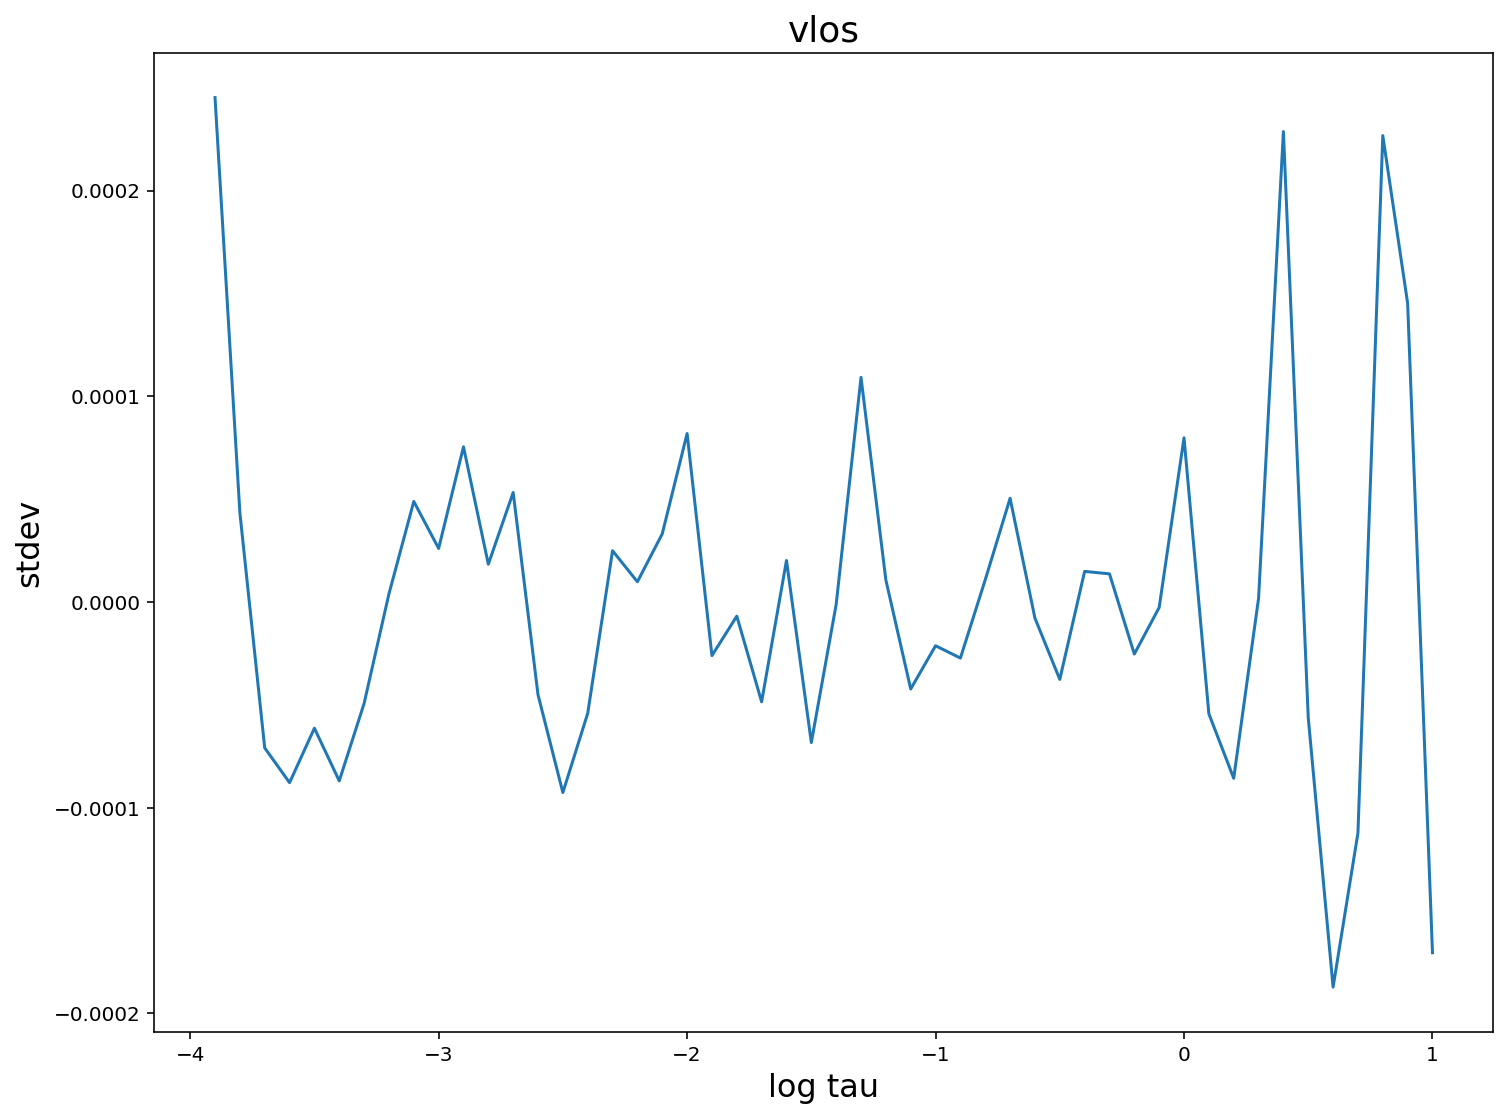

In [55]:
fig5 = plt.figure(figsize=(12,9))

#example spectra @10000
ax1 = fig5.add_subplot(1,1,1)
ax1.plot(atmos[0,:,0][0][u:l], stdev_arr_vlos)
#ax1.hist(chisq_arr_temp)
ax1.set_title("vlos", fontsize=18)
ax1.set_xlabel("log tau", fontsize=16)
ax1.set_ylabel("stdev", fontsize=16)

#fig4.savefig("Nice/hist112-test-O2.png")